### How to implement Pytorch custom activation functions?

There are four possibilities depending on what you are looking for. You will need to ask yourself two questions:

Q1) Will your activation function have learnable parameters?

If yes, you have no choice but to create your activation function as an nn.Module class because you need to store those weights.

If no, you are free to simply create a normal function, or a class, depending on what is convenient for you.

Q2) Can your activation function be expressed as a combination of existing PyTorch functions?

If yes, you can simply write it as a combination of existing PyTorch function and won't need to create a backward function which defines the gradient.

If no you will need to write the gradient by hand.

Example 1: Silu function

The silu (or swish) function $f(x) = x * sigmoid(x)$ does not have any learned weights and can be written entirely with existing PyTorch functions, thus you can simply define it as a function:

In [2]:
# Import PyTorch
import torch # import main library
import torch.nn as nn # import modules
import numpy as np

from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

import matplotlib.pyplot as plt

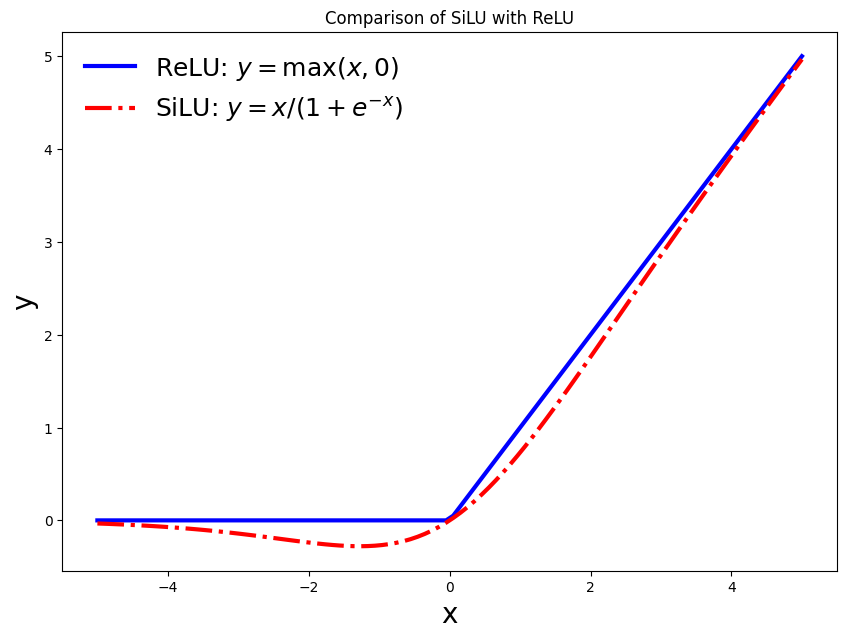

In [3]:
def swich(x):
    # Define the switch function by using the Sigmoid function element-wise:
    return x * torch.sigmoid(x)

# Create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models.
# Note that this function does not involve any parameter. 

class SiLU(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
    
        SiLU(x) = x * sigmoid(x)
        
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = SiLU()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        return x * torch.sigmoid(x) # silu(input) # simply apply already implemented SiLU
    
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of SiLU with ReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Create a silu function
swich = SiLU()
relu = nn.ReLU()

x = torch.linspace(-5, 5, 100)
# Plot the ReLU function
ax.plot(x, relu(x), label = 'ReLU: $y = \max(x, 0)$', linestyle='-', color='b', linewidth=3)
ax.plot(x, swich(x), label = 'SiLU: $y = x/(1+e^{-x})$', linestyle='-.', color='r', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

### Example 2: An activatiion function involving parameters

We modify the swich function by
$$   f(x) = a \frac{x}{1+e^{-x}},$$
where $a$ is a scale constant for controling the approximation to the ReLU. In this case, 
the constant is introduced from the initialization function of a class.

In [4]:
# Create a class wrapper from PyTorch nn.Module that involves a parameter, a
class mSiLU(nn.Module):
    '''
    Define a modified Sigmoid Linear Unit (SiLU) function element-wise:
    
        mSiLU(x) = a * x * sigmoid(x)
        
    where a is a scale parameter to control the approximation of SiLU to ReLU.

    Examples:
        >>> m = mSiLU()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, a = 1.0):
        super().__init__()
        self.a = torch.tensor(a)

    def forward(self, x):
        '''
        Forward (or apply) the function mSiLU to the input x.
        '''
        return self.a * x * torch.sigmoid(x)

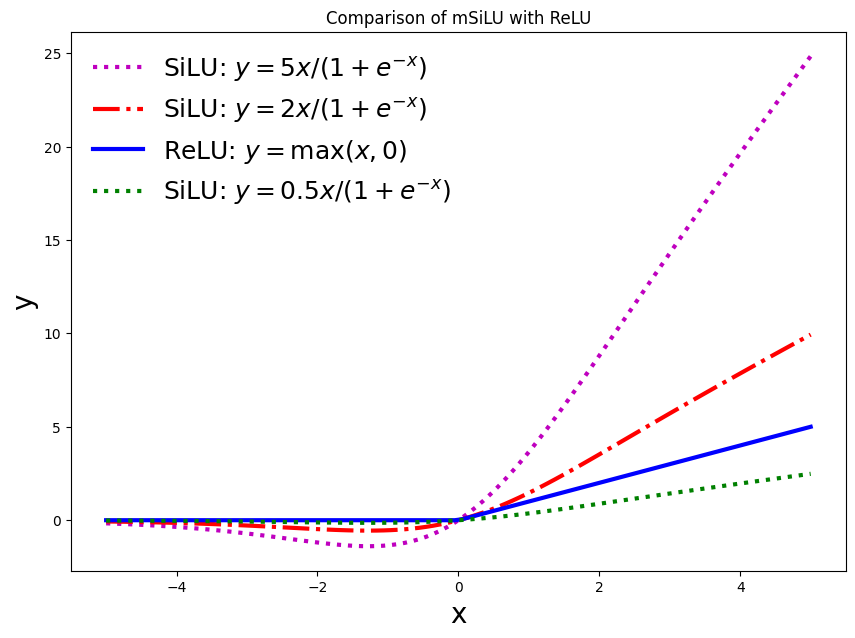

In [5]:
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mSiLU with ReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Create a silu function
swich1 = mSiLU(2.0) # with a = 2
swich2 = mSiLU(0.5) # with a = 0.5
swich3 = mSiLU(5.0) # with a = 5
relu = nn.ReLU()

x = torch.linspace(-5, 5, 100)
# Plot the ReLU function
ax.plot(x, swich3(x), label = 'SiLU: $y = 5 x / (1+e^{-x})$', linestyle=':', color='m', linewidth=3)
ax.plot(x, swich1(x), label = 'SiLU: $y = 2 x / (1+e^{-x})$', linestyle='-.', color='r', linewidth=3)
ax.plot(x, relu(x), label = 'ReLU: $y = \max(x, 0)$', linestyle='-', color='b', linewidth=3)
ax.plot(x, swich2(x), label = 'SiLU: $y = 0.5 x / (1+e^{-x})$', linestyle=':', color='g', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

### A modified ReLU activation function and its derivatives

$$        g(x) =  \left\{\begin{array}{cl} x & \mbox{if $x \geq h$}, \\
                          \frac{1}{4h}x^2 + \frac{1}{2} x + \frac{h}{4}  & \mbox{if $-h < x < h$}, \\  
                          0 & \mbox{if $x \leq -h$},
                         \end{array}\right.  \tag{1} $$
                         
where $h$ is a given parameter between 0 and 1. It is easy to show that $g$ is continuously differentiable on $-\infty < x < \infty$ but its second derivative does not exist at $x=0$. The first and second derivatives of $g$ can be found in the expressions:

$$        g^{\prime}(x) =  \left\{\begin{array}{cl} 1 & \mbox{if $x \geq h$}, \\
                          \frac{1}{2h}x + \frac{1}{2}  & \mbox{if $-h < x < h$}, \\  
                          0 & \mbox{if $x \leq -h$},
                         \end{array}\right.  \qquad 
g^"(x) =  \left\{\begin{array}{cl} 0 & \mbox{if $x \geq h$}, \\
                          \frac{1}{2h}  & \mbox{if $-h < x < h$}, \\  
                          0 & \mbox{if $x \leq -h$}.
                         \end{array}\right.     \tag{2}                
                         $$

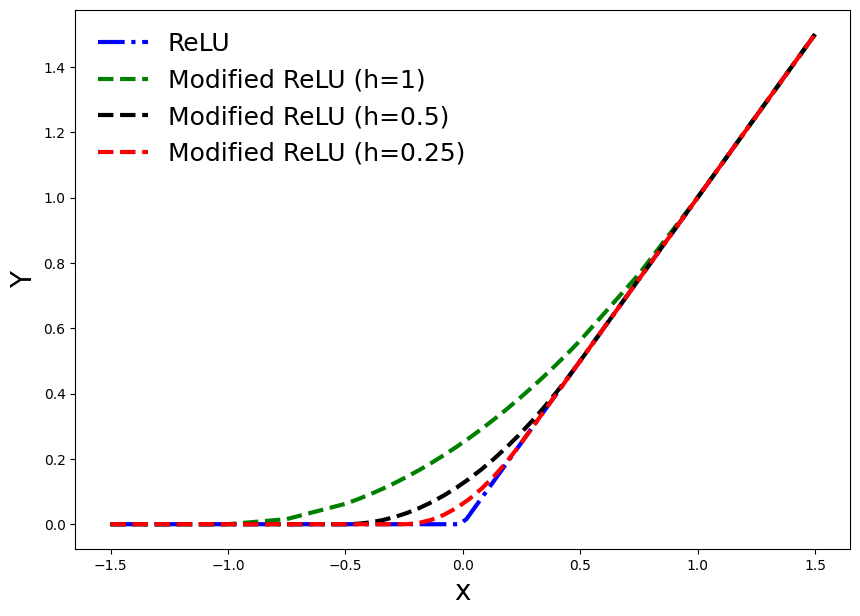

In [6]:
# Method 1: Use the np.piecewise function. However, it does not work for PyTorch.
def mRelu(x, h=0.2):
    # A modified ReLU activation function is defined by Eq. (1)
    y = lambda x: x*x / (4.0*h) + 0.5*x + h/4.0
    z = np.piecewise(x, [x <= -h, (x > -h) * (x < h), x >= h], [0, y, lambda x: x])
    return z

# Plot the function
fig = plt.figure(figsize=(10,7))
#ax = plt.axes()
#plt.title("A Modified ReLU Activation Function")
h = 0.5
# Set the interval [a, b]
a = -1.5
b = 1.5
n1 = 5 # Number of partition points
n = 20 # Number of partition points
x1 = np.linspace(a, -h, n1)
x2 = np.linspace(-h, h, n)
x3 = np.linspace(h, b, n1)
x = np.concatenate([x1,x2,x3])
#ax.plot(x, mRelu(x,h), '-g');

t = np.linspace(a, b, 100)
ReLU = np.piecewise(t, [t < 0, t >= 0], [0, lambda t: t])

#plt.figure()
plt.plot(t, ReLU, label = 'ReLU', linestyle='-.', color='b', linewidth=3)
plt.plot(x, mRelu(x,1.0), label = 'Modified ReLU (h=1)', linestyle='--', color='g', linewidth=3)
plt.plot(x, mRelu(x,0.5), label = 'Modified ReLU (h=0.5)', linestyle='--', color='k', linewidth=3)
plt.plot(x, mRelu(x,0.25), label = 'Modified ReLU (h=0.25)', linestyle='--', color='r', linewidth=3)
plt.xlabel("x", fontsize=20)
plt.ylabel("Y", fontsize=20)
#plt.xticks((Lz1, round(z_bottomProtein), Z1, 0, Z2, round(z_topProtein), Lz2), fontsize=18)
#plt.yticks(fontsize=18)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

### Way 2 for implementing mReLU

I implement the mReLU function in a Fortran routine and then convert it as a python function.

The routine implements the following python program for the efficiency of calculation:

```
     X = np.linspace(-5, 5, 100)
     h = 0.5
     fpr x in X:
       if x <= -h:
            return 0
        elif x >= h:
            return x
        else: 
            return 0.25*x*x/h + 0.5*x + 0.25*h
  
  ```  
  
torch.nn.functional.relu(input, inplace=False) → Tensor 
[SOURCE](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#relu)

Applies the rectified linear unit function element-wise. See ReLU for more details.

In [10]:
!pip install ToolsFortran

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement ToolsFortran (from versions: none)
ERROR: No matching distribution found for ToolsFortran


In [9]:
# Create a class wrapper from PyTorch nn.Module that involves a piecewise function and parameter h
import ToolsFortran

class mReLU(nn.Module):
    '''
    Define a modified Rectified Linear Unit (ReLU) function, mReLU(x), by Eq. (1). 
    Here h is a parameter to control the approximation of mReLU to ReLU.

    Examples:
        >>> h = 0.5
        >>> m = mSiLU(h)
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, h = 0.5):
        super().__init__()
        self.h = h

    def forward(self, x):
        '''
        Forward means that we apply the function mSiLU to the input x.
        '''
        h = self.h 
        z = ToolsFortran.mrelu2d(x, h)
        y = torch.from_numpy(z)

        return y
        
mrelu = mReLU(0.50) # with h = 0.5
x = torch.linspace(-5, 5, 100)
y = mrelu(x)

ModuleNotFoundError: ignored

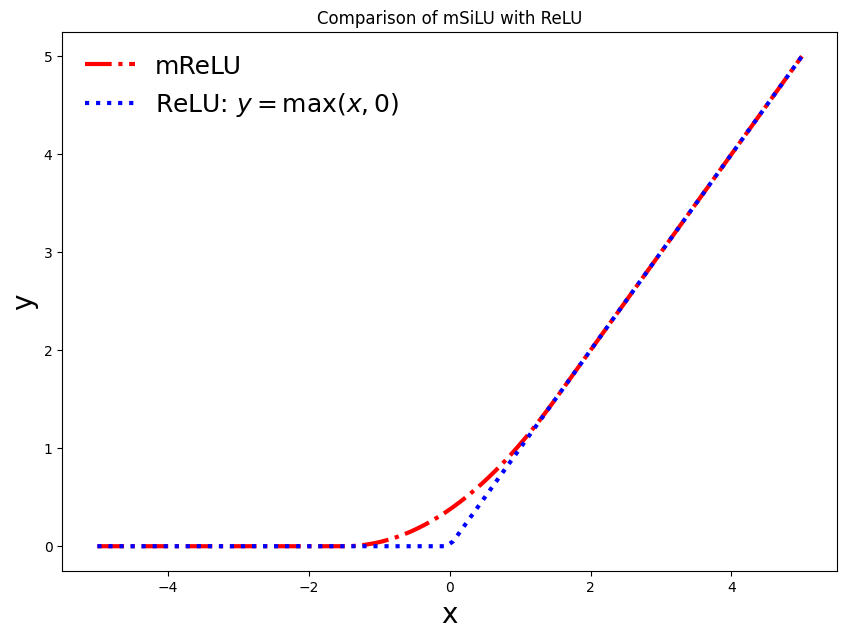

In [ ]:
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mSiLU with ReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Create a silu function
swich1 = mReLU(1.50) # with h = 0.5
relu = nn.ReLU()

x = torch.linspace(-5, 5, 100)
# Plot the ReLU function
#ax.plot(x, swich3(x), label = 'SiLU: $y = 5 x / (1+e^{-x})$', linestyle=':', color='m', linewidth=3)
ax.plot(x, swich1(x), label = 'mReLU', linestyle='-.', color='r', linewidth=3)
ax.plot(x, relu(x), label = 'ReLU: $y = \max(x, 0)$', linestyle=':', color='b', linewidth=3)
#ax.plot(x, swich2(x), label = 'SiLU: $y = 0.5 x / (1+e^{-x})$', linestyle=':', color='g', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

### Way 3: Implement mReLU for PyTorch

We use torch.where to implement the piecewise function of mReLU. It can be seen that
the following python program 
```
     if x>h:
         return x
     elif x<-h:
         return 0
     else:
         return 1/(4*h)*x*x + 1/2*x + 1/4*h
```
is equivalent to the following python code:

```
     y = torch.zeros(x.shape).to(device)
     z = torch.where(x>h, x, torch.where(x<-h, y, 1/(4*h)*x*x + 1/2*x + 1/4*h))
```

In [11]:
class mReLU(nn.Module):
    # Define mReLU as a subclass of nn.Module. We then modify 
    #   two methods: include __init__ and forward
    def __init__(self, h=0.5): 
        super(mReLU, self).__init__()
        self.h = h

    def forward(self, x):
        h=self.h
        zero = 0.0
        return torch.where(x>h, x, torch.where(x<-h, zero*x, 1/(4*h)*x*x + 1/2*x + 1/4*h))

mrelu = mReLU(0.50) # with h = 0.5
x = torch.linspace(-5, 5, 100)
y = mrelu(x)
type(y)

torch.Tensor

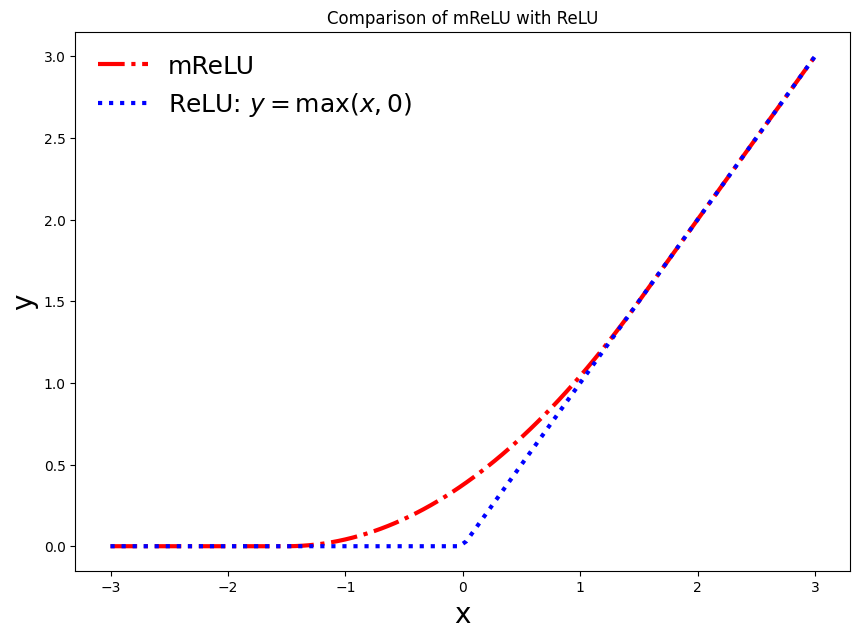

In [12]:
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mReLU with ReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Create a silu function
mrelu = mReLU(1.50) # with h = 0.5
relu = nn.ReLU()

x = torch.linspace(-3, 3, 100)
# Plot the ReLU function
ax.plot(x, mrelu(x), label = 'mReLU', linestyle='-.', color='r', linewidth=3)
ax.plot(x, relu(x), label = 'ReLU: $y = \max(x, 0)$', linestyle=':', color='b', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

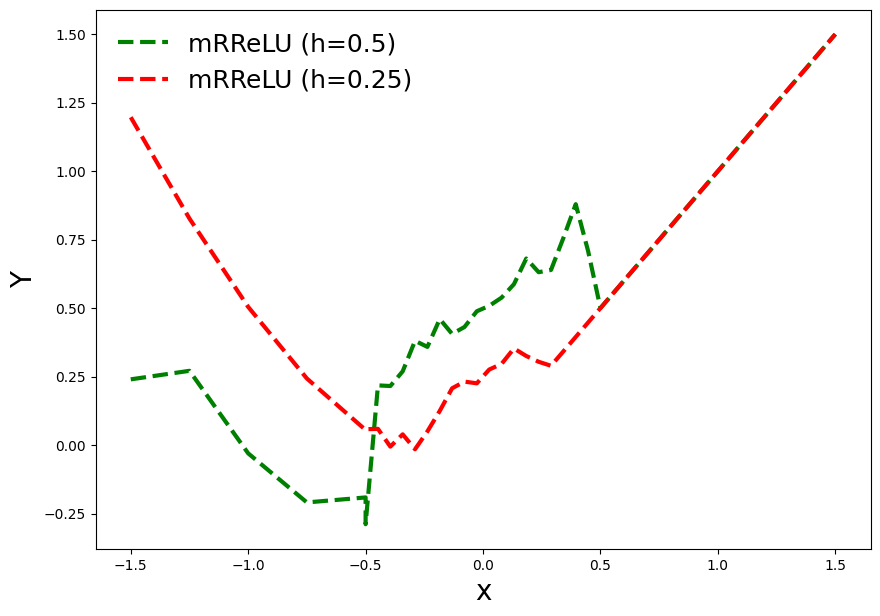

In [14]:
def mRRelu(x, h=0.2):
    # A modified randomized leaky rectified linear unit (mRReLU) activation function
    y = lambda x: x * np.random.uniform(low=0.2, high=1.0, size=x.shape) + h
    z = np.piecewise(x, [x <= -h, (x > -h) * (x < h), x >= h], [lambda x: -y(x), y, lambda x: x])
    return z

# Plot the function
fig = plt.figure(figsize=(10,7))
h = 0.5
# Set the interval [a, b]
a = -1.5
b = 1.5
n1 = 5 # Number of partition points
n = 20 # Number of partition points
x1 = np.linspace(a, -h, n1)
x2 = np.linspace(-h, h, n)
x3 = np.linspace(h, b, n1)
x = np.concatenate([x1,x2,x3])

t = np.linspace(a, b, 100)
ReLU = np.piecewise(t, [t < 0, t >= 0], [0, lambda t: t])

#plt.plot(t, ReLU, label='ReLU', linestyle='-.', color='b', linewidth=3)
plt.plot(x, mRRelu(x, 0.5), label='mRReLU (h=0.5)', linestyle='--', color='g', linewidth=3)
plt.plot(x, mRRelu(x, 0.25), label='mRReLU (h=0.25)', linestyle='--', color='r', linewidth=3)
plt.xlabel("x", fontsize=20)
plt.ylabel("Y", fontsize=20)
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.show()



In [28]:
class mRReLU(nn.Module):
    # Define mmRReLU as a subclass of nn.Module. We then modify 
    # two methods: include __init__ and forward
    def __init__(self, h=0.5, c=0.1): 
        super(mRReLU, self).__init__()
        self.h = h
        self.c = c

    def forward(self, x):
        h=self.h
        c=self.c
        zero = 0.0
        return torch.where(x>h, x, torch.where(x<-h, c*x, 1/(4*h)*x*x + (1-c)/(2*h)*x + 1/4*h))

mrrelu = mRReLU(0.50, 0.25) # with h = 0.5, c=0.25
x = torch.linspace(-5, 5, 100)
y = mrrelu(x)
type(y)

torch.Tensor

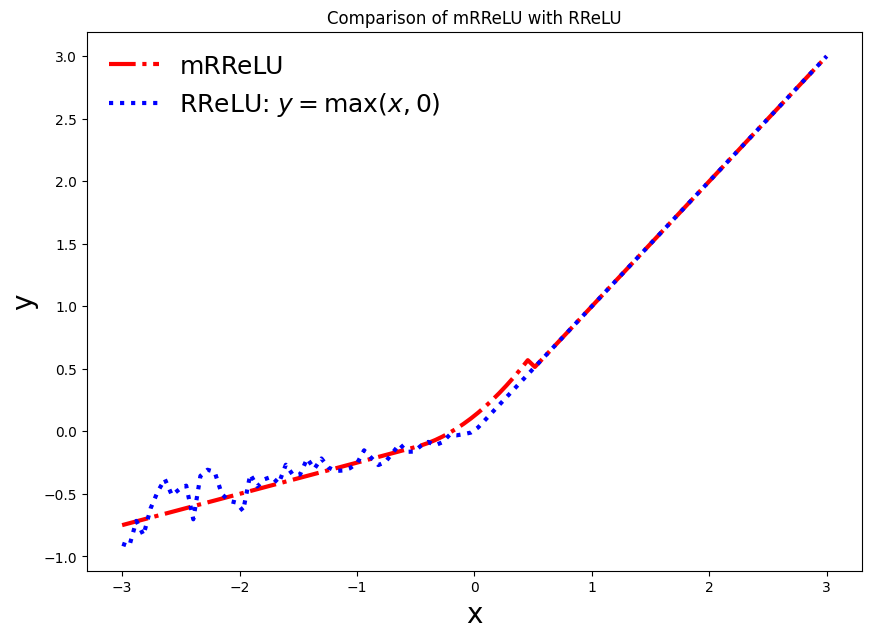

In [29]:
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mRReLU with RReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Create a ReLU function
relu = nn.RReLU()

x = torch.linspace(-3, 3, 100)
# Plot the ReLU function
ax.plot(x, mrrelu(x), label = 'mRReLU', linestyle='-.', color='r', linewidth=3)
ax.plot(x, relu(x), label = 'RReLU: $y = \max(x, 0)$', linestyle=':', color='b', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

In [ ]:
# Create a class wrapper from PyTorch nn.Module that involves a piecewise function and parameter h
import ToolsFortran
class mRReLU(nn.Module):
    '''
    Define a modified Randomized Rectified Linear Unit (RReLU) function, mRReLU(x), by Eq. (2). 
    Here h and c are parameters to control the approximation of mRReLU to RReLU.

    Examples:
        >>> h = 0.5
        >>> c = 1.0
        >>> m = mRReLU(h, c)
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, h=0.5, c=1.0): 
        super(mRReLU, self).__init__()
        self.h = h
        self.c = c

    def forward(self, x):
        h = self.h
        c = self.c
        zero = 0.0
        z = ToolsFortran.mrrelu2d(x, h, c)
        y = torch.from_numpy(z)

        return y

mrrelu = mRReLU(0.50, 0.25) # with h = 0.5, c=0.25
x = torch.linspace(-5, 5, 100)
y = mrrelu(x)


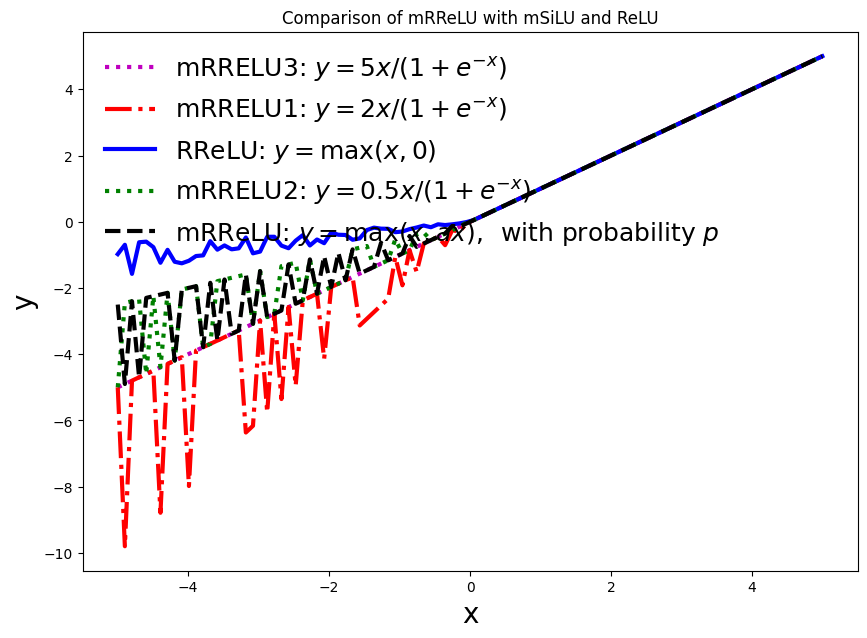

In [44]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class mRReLU(nn.Module):
    '''
    Define a modified Randomized Rectified Linear Unit (mRReLU) function element-wise:
    
        mRReLU(x) = { x, with probability p, a * x, with probability (1-p)}, if x <= 0
                    x, if x > 0
        
    where a is a scale parameter to control the slope of the negative part of the function, 
    and p is a probability parameter to control the fraction of the negative part of the function.

    Examples:
        >>> m = mRReLU()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, a=0.5, p=0.5):
        super().__init__()
        self.a = a
        self.p = p

    def forward(self, x):
        '''
        Forward (or apply) the function mRReLU to the input x.
        '''
        u = torch.rand_like(x)
        mask = (u < self.p).float()

        return mask * x + (1 - mask) * self.a * x * (x <= 0).float() + (1 - mask) * x * (x > 0).float()




# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mRReLU with mSiLU and ReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

mrrelu1 = mRReLU(a=2, p=0.5) # with a = 2
mrrelu2 = mRReLU(a=0.5, p=0.5) # with a = 0.5
mrrelu3 = mRReLU(a=1, p=0.5) # with a = 5
rrelu = nn.RReLU()
mrrelu = mRReLU(a=0.5, p=0.5)

x = torch.linspace(-5, 5, 100)

ax.plot(x, mrrelu3(x), label = 'mRRELU3: $y = 5 x / (1+e^{-x})$', linestyle=':', color='m', linewidth=3)
ax.plot(x, mrrelu1(x), label = 'mRRELU1: $y = 2 x / (1+e^{-x})$', linestyle='-.', color='r', linewidth=3)
ax.plot(x, rrelu(x), label = 'RReLU: $y = \max(x, 0)$', linestyle='-', color='b', linewidth=3)
ax.plot(x, mrrelu2(x), label = 'mRRELU2: $y = 0.5 x / (1+e^{-x})$', linestyle=':', color='g', linewidth=3)
ax.plot(x, mrrelu(x), label = 'mRReLU: $y = \max(x, ax),\, $ with probability $p$', linestyle='--', color='k', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)



In [45]:
class mtanh(nn.Module):
    # Define mtanh as a subclass of nn.Module. We then modify 
    # two methods: include __init__ and forward
    def __init__(self, h=0.5): 
        super(mtanh, self).__init__()
        self.h = h

    def forward(self, x):
        h=self.h
        return torch.where(x>h, torch.ones_like(x), torch.where(x<-h, -torch.ones_like(x), x/h))

mt = mtanh(0.5) # with h = 0.5
x = torch.linspace(-5, 5, 100)
y = mt(x)
type(y)


torch.Tensor

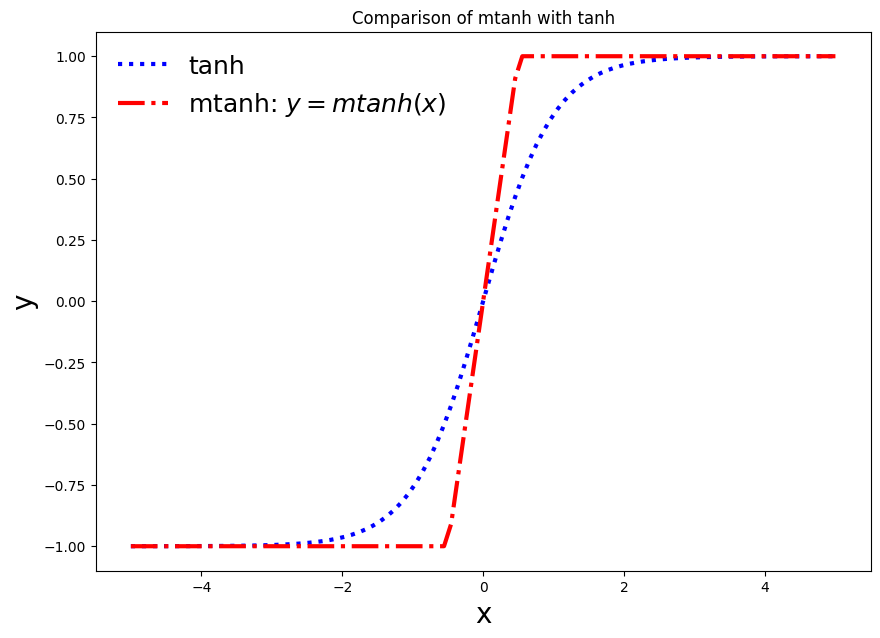

In [46]:
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mtanh with tanh")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

tanh = nn.Tanh()
mtanh = mtanh(0.5)
x = torch.linspace(-5, 5, 100)

# Plot the tanh function
ax.plot(x, tanh(x), label = 'tanh', linestyle=':', color='b', linewidth=3)

# Plot the mtanh function
ax.plot(x, mtanh(x), label = 'mtanh: $y = mtanh(x)$', linestyle='-.', color='r', linewidth=3)

plt.legend(loc='upper left',fontsize=18, framealpha=0.0)


In [ ]:
# Create a class wrapper from PyTorch nn.Module that involves a piecewise function and parameter h
import ToolsFortran

class mtanh(nn.Module):
    '''
    Define a modified hyperbolic tangent (tanh) function, mtanh(x), by Eq. (2).
    Here h is a parameter to control the approximation of mtanh to tanh.

    Examples:
        >>> h = 0.5
        >>> m = mtanh(h)
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self, h=0.5):
        super().__init__()
        self.h = h

    def forward(self, x):
        h = self.h
        z = ToolsFortran.mtanh2d(x, h)
        y = torch.from_numpy(z)
        return y

mtanh = mtanh(0.5) # with h = 0.5
x = torch.linspace(-5, 5, 100)
y = mtanh(x)


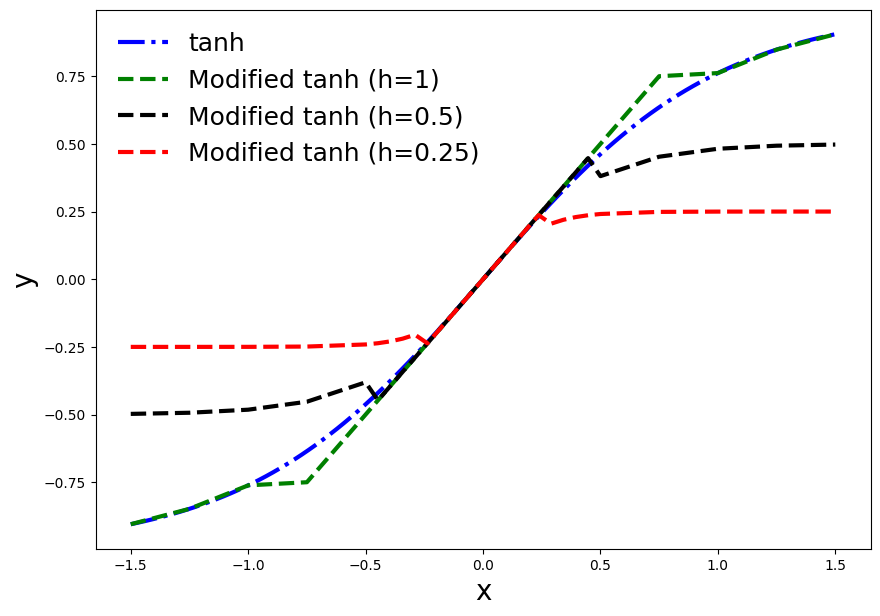

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def mtanh(x, h=0.2):
    y = lambda x: h*np.tanh(x/h)
    z = np.piecewise(x, [x <= -h, (x > -h) * (x < h), x >= h], [y, lambda x: x, y])
    return z

# Plot the function
fig = plt.figure(figsize=(10,7))

h = 0.5
a = -1.5
b = 1.5
n1 = 5
n = 20
x1 = np.linspace(a, -h, n1)
x2 = np.linspace(-h, h, n)
x3 = np.linspace(h, b, n1)
x = np.concatenate([x1,x2,x3])

t = np.linspace(a, b, 100)

plt.plot(t, np.tanh(t), label='tanh', linestyle='-.', color='b', linewidth=3)
plt.plot(x, mtanh(x, 1.0), label='Modified tanh (h=1)', linestyle='--', color='g', linewidth=3)
plt.plot(x, mtanh(x, 0.5), label='Modified tanh (h=0.5)', linestyle='--', color='k', linewidth=3)
plt.plot(x, mtanh(x, 0.25), label='Modified tanh (h=0.25)', linestyle='--', color='r', linewidth=3)

plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.show()



In [49]:
class mtanh(nn.Module):
    '''
    Define a modified hyperbolic tangent (mtanh) function element-wise:
    
        mtanh(x) = a * tanh(x)
        
    where a is a scale parameter to control the approximation of mtanh to ReLU.

    Examples:
        >>> m = mtanh()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, a=1.0):
        super().__init__()
        self.a = torch.tensor(a)

    def forward(self, x):
        '''
        Forward (or apply) the function mtanh to the input x.
        '''
        return self.a * torch.tanh(x)


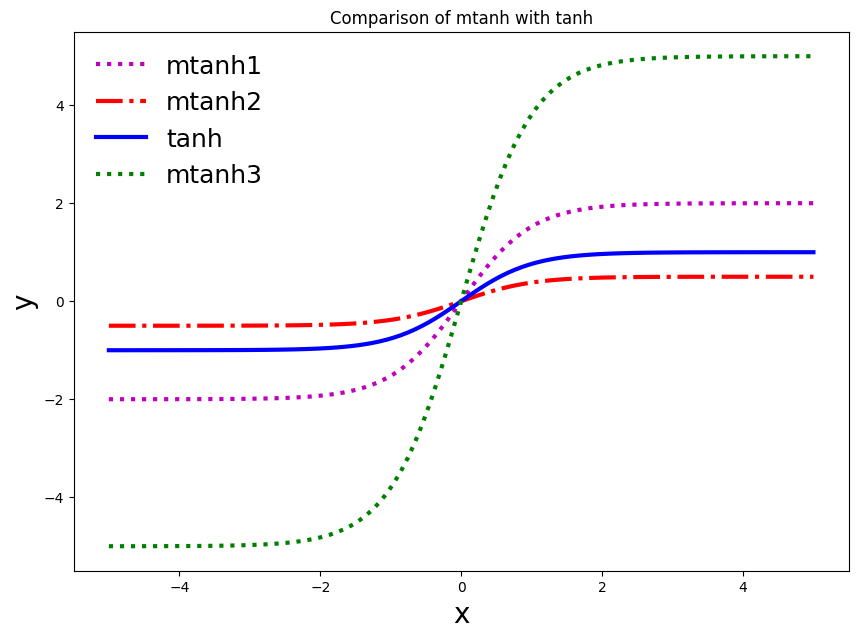

In [51]:
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mtanh with tanh")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Create a silu function
mtanh1 = mtanh(2.0) # with a = 2
mtanh2 = mtanh(0.5) # with a = 0.5
mtanh3 = mtanh(5.0) # with a = 5
tanh = nn.Tanh()

x = torch.linspace(-5, 5, 100)
# Plot the ReLU function
ax.plot(x, mtanh1(x), label = 'mtanh1', linestyle=':', color='m', linewidth=3)
ax.plot(x, mtanh2(x), label = 'mtanh2', linestyle='-.', color='r', linewidth=3)
ax.plot(x, tanh(x), label = 'tanh', linestyle='-', color='b', linewidth=3)
ax.plot(x, mtanh3(x), label = 'mtanh3', linestyle=':', color='g', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)